# Performance Measures for Binary Classification

This notebook provides performance evaluation measures for binary classification models, including discrimination, calibration, and classification metrics. It supports the results present in Van Calster et al (2025).

The code can be downloaded for local execution in: File > Download as > Python (.py)

In [ ]:
!pip install localreg
import pandas as pd
import numpy as np
from scipy.stats import rankdata, binom
from scipy.ndimage import uniform_filter1d
from sklearn.metrics import roc_auc_score, precision_recall_curve, log_loss, mean_squared_error, auc, roc_curve, confusion_matrix
from statsmodels.api import Logit
from statsmodels.formula.api import glm
from statsmodels.genmod.families import Binomial
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.calibration import calibration_curve
import seaborn as sns
from localreg import localreg
import os

# Set working directory (if needed)
os.chdir(os.path.dirname(os.path.abspath("Performance measures paper 20oct2024.py")))

In [ ]:
# Figures params
plt.rcParams.update({
    'axes.titlesize': 16,       # Title size
    'axes.labelsize': 14,       # X and Y label size
    'xtick.labelsize':12,      # X tick label size
    'ytick.labelsize': 12,      # Y tick label size
    'legend.fontsize':12,      # Legend text size
    'font.size': 12             # Overall font size
})

### Define Helper Functions

In [ ]:
def fastAUC(p, y):
    x1 = p[y == 1]
    n1 = len(x1)
    x2 = p[y == 0]
    n2 = len(x2)
    r = rankdata(np.concatenate([x1, x2]))
    auc = (np.sum(r[:n1]) - n1 * (n1 + 1) / 2) / (n1 * n2)
    return auc

In [ ]:
# Function to calculate average precision
def avgprec(p, y):
    probsort = np.sort(p)
    prcpts = pd.DataFrame(np.nan, index=range(len(probsort)), columns=range(3))
    for i in range(len(probsort)):
        prcpts.iloc[i, 0] = np.sum(p[y == 1] >= probsort[i]) / np.sum(y == 1)
        prcpts.iloc[i, 1] = np.sum(p[y == 1] >= probsort[i]) / np.sum(p >= probsort[i])
    for i in range(len(probsort)):
        prcpts.iloc[i, 2] = prcpts.iloc[i, 1] * (prcpts.iloc[i, 0] if i == len(probsort) - 1 else prcpts.iloc[i, 0] - prcpts.iloc[i + 1, 0])
    return np.sum(prcpts.iloc[:, 2])

In [ ]:
# Function to calculate discrimination performance
def DiscPerfBin(y, p,  sensitivity_limit=0.8):
    # Ensure that y and p are numpy arrays for compatibility
    y = np.asarray(y)
    p = np.asarray(p)

    # Compute the C-statistic (AUC)
    cstat = fastAUC( p, y)

    # Compute precision and recall
    precisions, recalls, _ = precision_recall_curve(y, p)
    auprc = auc(recalls, precisions)  # Note: AUC of the precision-recall curve
    ap = avgprec(p, y)

    # Calculate TPR and FPR
    thresholds = np.linspace(0, 1, 100)
    tpr = np.array([np.sum((p >= threshold) & (y == 1)) / np.sum(y == 1) for threshold in thresholds])
    fpr = np.array([np.sum((p >= threshold) & (y == 0)) / np.sum(y == 0) for threshold in thresholds])

    # Thresholding for TPR
    tpr_threshold = sensitivity_limit
    partial_fpr = fpr[tpr >= tpr_threshold]
    partial_tpr = tpr[tpr >= tpr_threshold]

    # Compute the adjusted TPR
    adjusted_tpr = partial_tpr - tpr_threshold

    # Compute the partial AUC
    p_auc = -np.trapz(adjusted_tpr, partial_fpr)

    # Return the results as a DataFrame
    return pd.DataFrame([[cstat, auprc, ap, p_auc]], columns=["AUROC", "AUPRC", "AP", "pAUROC"])



In [ ]:
# Function to calculate calibration performance
def CalPerfBin(y, p, flexcal="loess", ngr=10):
    oe = np.sum(y) / np.sum(p)
    logit_p = np.log(p / (1 - p))
    int_model = Logit(y, np.ones_like(y), offset= logit_p).fit(disp=0)
    intcpt = int_model.params.iloc[0]
    sl_model = LogisticRegression().fit(y = y, X = np.array(logit_p).reshape(-1, 1))
    slope = sl_model.coef_[0][0]
    flc = localreg(y = np.array(y), x = np.array(p), frac=0.75,degree = 2) if flexcal == "loess" else None
    # Go to R code for splines based flexible calibration
    eci = np.mean((flc - p)**2)/ np.mean( (np.full(y.shape, np.mean(y), dtype=float)-p)**2)
    ici = np.mean(np.abs(flc - p))

    hsl = pd.DataFrame({'x': p, 'y': y})
    hsl['x_quantile'] = pd.qcut(hsl['x'], q=ngr)
    mean_hsl = hsl.groupby('x_quantile', observed = True).agg(mean_x=('x', 'mean'), mean_y=('y', 'mean')).reset_index()

    ece =  (abs(mean_hsl['mean_x'] - mean_hsl['mean_y'])).mean()  # Placeholder for ECE with grouping in 'ngr'
    return pd.DataFrame([[oe, intcpt, slope, eci, ici, ece]], columns=["O:E ratio", "Cal. intercept", "Cal. slope", "ECI", "ICI", "ECE"])


In [ ]:
# Function to calculate overall performance
def OvPerfBin(y, p):
    lli = np.sum(binom.logpmf(y, n=1, p=p))
    ll0 = np.sum(binom.logpmf(y, n=1, p=np.full(len(y), np.mean(y))))
    llo = log_loss(y, p, normalize=False)
    br = mean_squared_error(y, p)
    bss = 1 - (mean_squared_error(y, p) / mean_squared_error(y, np.full(y.shape, np.mean(y), dtype=float)))
    mfr2 = 1 - (lli / ll0)
    csr2 = 1 - np.exp(2 * (ll0 - lli) / len(y))
    nr2 = csr2 / (1 - np.exp(2 * ll0 / len(y)))
    ds = np.mean(p[y == 1]) - np.mean(p[y == 0])
    mape = np.mean(np.abs(y - p))
    return pd.DataFrame([[lli, llo, br, bss, mfr2, csr2, nr2, ds, mape]], columns=["Loglikelihood", "Logloss", "Brier", "Scaled Brier", "McFadden R2", "Cox-Snell R2", "Nagelkerke R2", "Discrimination slope", "MAPE"])


In [ ]:
# Function to calculate classification performance
def ClassPerfBin(y, p, cut):
    TP = np.mean((p >= cut) & (y == 1))
    FN = np.mean((p < cut) & (y == 1))
    TN = np.mean((p < cut) & (y == 0))
    FP = np.mean((p >= cut) & (y == 0))
    Sens = TP / (TP + FN)
    Spec = TN / (TN + FP)
    PPV = TP / (TP + FP)
    NPV = TN / (TN + FN)
    Acc = TP + TN
    Bar = 0.5 * (Sens + Spec)
    You = Sens + Spec - 1
    DOR = (Sens / (1 - Spec)) / ((1 - Sens) / Spec)
    Acc_E = np.mean(y) * (TP + FP) + (1 - np.mean(y)) * (FN + TN)
    Kap = (Acc - Acc_E) / (1 - Acc_E)
    F1 = 2 * ((PPV * Sens) / (PPV + Sens))
    MCC = (TP * TN - FP * FN) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    return pd.DataFrame([[Acc, Bar, You, DOR, Kap, F1, MCC, Sens, Spec, PPV, NPV]], columns=["Accuracy", "Balanced Accuracy", "Youden index", "DOR", "Kappa", "F1", "MCC", "Sensitivity", "Specificity", "PPV", "NPV"])


In [ ]:
# Function to calculate utility performance
def UtilPerfBin(y, p, cut, costratio):
    NB = np.mean((p >= cut) * (y == 1)) - (cut / (1 - cut)) * np.mean((p >= cut) * (y == 0))
    SNB = NB / np.mean(y)
    risksort = np.sort(p)
    ecpts = pd.DataFrame(np.nan, index=range(len(risksort)), columns=range(3))
    for i in range(len(risksort)):
        ecpts.iloc[i, 0] = np.sum(p[y == 1] < risksort[i]) / np.sum(y == 1)
        ecpts.iloc[i, 1] = np.sum(p[y == 0] >= risksort[i]) / np.sum(y == 0)
        ecpts.iloc[i, 2] = (ecpts.iloc[i, 0] * np.mean(y) * (costratio if costratio > 1 else 1) + ecpts.iloc[i, 1] * (1 - np.mean(y)) * (1 if costratio > 1 else costratio))
    EC = np.min(ecpts.iloc[:, 2])
    ECthreshold = risksort[np.argmin(ecpts.iloc[:, 2])]
    return pd.DataFrame([[NB, SNB, EC, ECthreshold]], columns=["Net benefit", "Standardized net benefit", "Expected cost", "Threshold for EC"])

def net_benefit(y_true, probabilities, thresholds):
    """Calculate the Net Benefit (NB) at each threshold."""
    nb_values = []
    for threshold in thresholds:
        tp = np.sum((probabilities >= threshold) & (y_true == 1))
        fp = np.sum((probabilities >= threshold) & (y_true == 0))
        nb = (tp / len(y_true)) - (fp / len(y_true)) * (threshold / (1 - threshold))
        nb_values.append(nb)

    return np.array(nb_values)
def net_benefit_all(y_true, probabilities, thresholds):
    """Calculate Standardized Net Benefit (NB) at each threshold."""
    nb_values = []
    for threshold in thresholds:
        tp = np.sum((probabilities >= 0) & (y_true == 1))
        fp = np.sum((probabilities >= 0) & (y_true == 0))
        nb = (tp / len(y_true)) - (fp / len(y_true)) * (threshold / (1 - threshold))
        nb_values.append(nb)
    return np.array(nb_values)

# Function to get data for a plot of EC
# Input:
#  p: vector with risk estimates
#  y: vector with outcomes, i.e. 0 or 1
#  ncostfp: normalized costs of false positive to be used
#  for calculating EC values; normalized means both costs sum to one, such that
#  the normalized cost of a false negative is 1 minus the normalized cost of a
#  false positive
def ecplotv(y, p, ncostfp):
    risksort = np.sort(p)
    ec_res = pd.DataFrame(np.nan, index=[0, 1], columns=range(len(ncostfp)))
    for i, cost_fp in enumerate(ncostfp):
        ecpts = pd.DataFrame(np.nan, index=range(len(risksort)), columns=[0, 1, 2])

        for j, threshold in enumerate(risksort):
            fn_rate = np.sum(p[y == 1] < threshold) / np.sum(y == 1)
            fp_rate = np.sum(p[y == 0] >= threshold) / np.sum(y == 0)
            ec_value = (fn_rate * np.mean(y) * (1 - cost_fp) +
                        fp_rate * (1 - np.mean(y)) * cost_fp)

            ecpts.iloc[j, 0] = fn_rate
            ecpts.iloc[j, 1] = fp_rate
            ecpts.iloc[j, 2] = ec_value

        ec_res.iloc[0, i] = ecpts.iloc[:, 2].min()
        ec_res.iloc[1, i] = risksort[ecpts.iloc[:, 2].idxmin()]

    return ec_res


### Load Data and Perform Analysis

In [ ]:
dcase = pd.read_csv('https://raw.githubusercontent.com/benvancalster/PerfMeasuresOverview/refs/heads/main/data_case_study.txt', sep=' ', na_values=[''])
dcase['Out1'] = dcase['Outcome1'].map({0: 'Benign', 1: 'Malignant'})
dcase = dcase[['Outcome1', 'Out1', 'pmalwo']]
dcase['logit_pmalwo'] = np.log(dcase['pmalwo'] / (1 - dcase['pmalwo']))

### Discrimination performance

In [ ]:
# Discrimination Performance - AUROC calculation
fpr, tpr, _ = roc_curve(dcase['Outcome1'], dcase['pmalwo'])
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(dcase['Outcome1'], dcase['pmalwo'])
pr_auc = auc(recall, precision)

# Partial AUROC (pAUROC) - Considering only specific ranges of sensitivity

# Select points where TPR is above the threshold
tpr_threshold = 0.8
partial_fpr = fpr[tpr >= tpr_threshold]
partial_tpr = tpr[tpr >= tpr_threshold]

adjusted_tpr = partial_tpr - tpr_threshold

# Compute the partial AUC above TPR = 0.8
partial_auc_above_threshold = np.trapz(adjusted_tpr, partial_fpr)


# All together
DiscADNEX = DiscPerfBin(dcase['Outcome1'], dcase['pmalwo'])
DiscADNEX

,AUROC,AUPRC,AP,pAUROC
0,0.911385,0.894914,0.895251,0.141224


#### Discrimination figures

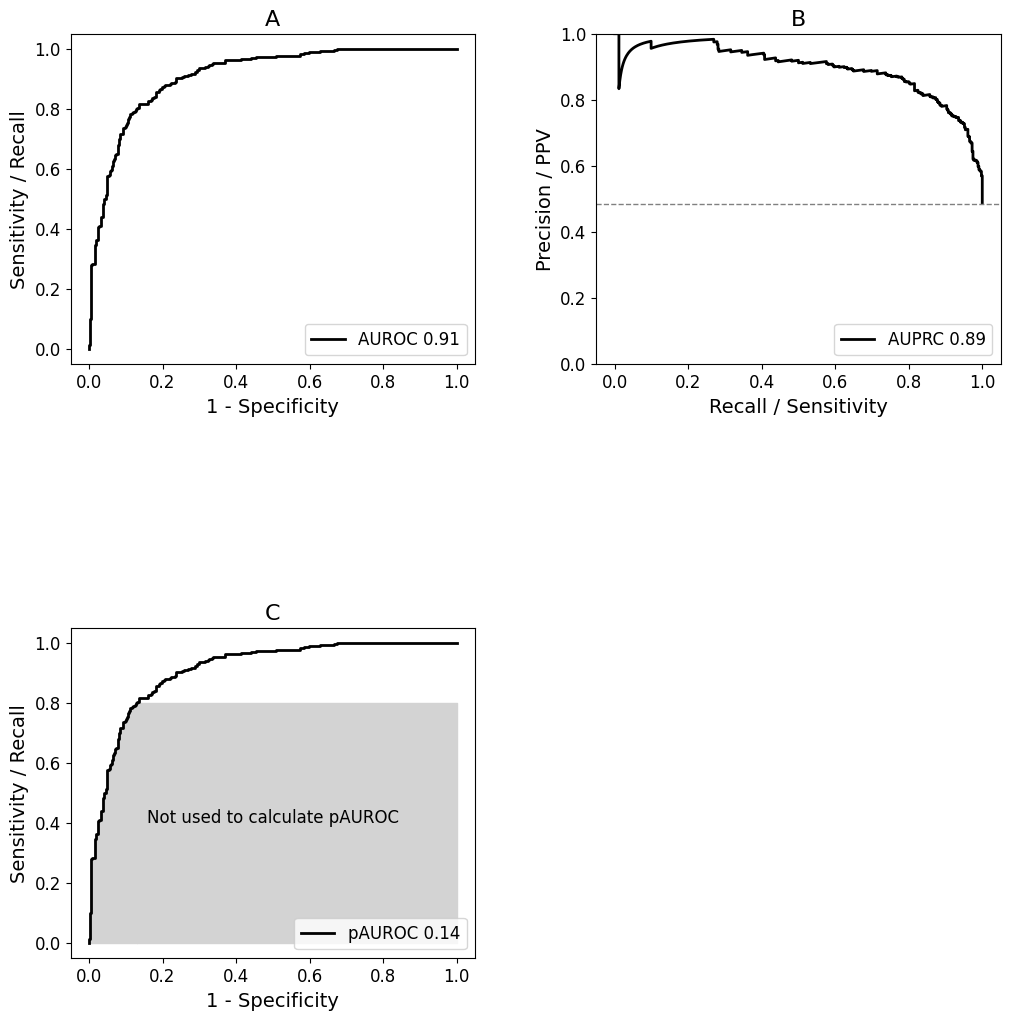

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
# Panel A: ROC Curve
axs[0, 0].plot(fpr, tpr, color='black', lw=2)
axs[0, 0].set_title("A")
axs[0, 0].set_xlabel("1 - Specificity")
axs[0, 0].set_ylabel("Sensitivity / Recall")
axs[0, 0].legend([f'AUROC {roc_auc:.2f}'], loc='lower right')

# Panel B: PR Curve
axs[0, 1].plot(recall, precision, color='black', lw=2)
axs[0, 1].axhline(y=dcase['Outcome1'].mean(), color='gray', lw=1, linestyle="--")
axs[0, 1].set_ylim([0, 1])
axs[0, 1].set_title("B")
axs[0, 1].set_xlabel("Recall / Sensitivity")
axs[0, 1].set_ylabel("Precision / PPV")
axs[0, 1].legend([f'AUPRC {pr_auc:.2f}'], loc='lower right')

# Panel C: Partial ROC Curve
axs[1, 0].plot(fpr, tpr, color='black', lw=2)
axs[1, 0].fill_between(fpr, tpr, where=(tpr <= tpr_threshold), color="lightgray", step="post")
axs[1, 0].fill_between(fpr, 0.8, where=(tpr > tpr_threshold), color="lightgray", step="post")
axs[1, 0].text(0.5, 0.4, "Not used to calculate pAUROC", ha="center")
axs[1, 0].set_title("C")
axs[1, 0].set_xlabel("1 - Specificity")
axs[1, 0].set_ylabel("Sensitivity / Recall")
axs[1, 0].legend([f'pAUROC {partial_auc_above_threshold:.2f}'], loc='lower right')

fig.delaxes(axs[1,1])
plt.subplots_adjust(wspace=0.3, hspace=0.2)  # Increase space between plots
plt.show()

### Calibration performance

In [ ]:
CalADNEX = CalPerfBin(y = dcase['Outcome1'], p = dcase['pmalwo'], flexcal = "loess", ngr = 10)
CalADNEX

,O:E ratio,Cal. intercept,Cal. slope,ECI,ICI,ECE
0,1.228075,0.809578,0.930375,0.104186,0.094348,0.091138


#### Calibration figures



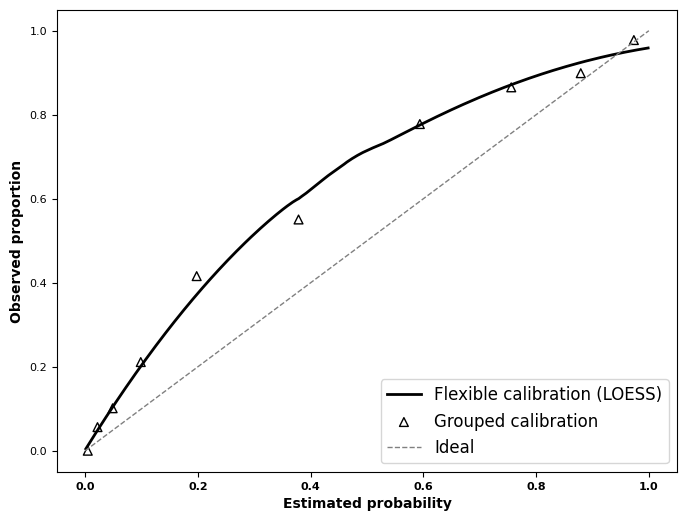

In [ ]:
loess_adnex = localreg(x=np.array(dcase['pmalwo']), y=np.array(dcase['Outcome1']), frac=0.75, degree=2)
dcase["loess"] = loess_adnex
dcase = dcase.sort_values(by="loess")

ngr = 10
hsl = pd.DataFrame({'x': dcase['pmalwo'], 'y': dcase['Outcome1']})
hsl['x_quantile'] = pd.qcut(hsl['x'], q=ngr)
mean_hsl = hsl.groupby('x_quantile', observed=True).agg(mean_x=('x', 'mean'), mean_y=('y', 'mean')).reset_index()

# Confidence intervals obtained through bootstrap available in val.prob.ci.2 function in R
# of the CalibrationCurves package
plt.figure(figsize=(8, 6))
plt.plot(dcase['pmalwo'], dcase['loess'], color='black', lw=2)
plt.scatter(mean_hsl['mean_x'], mean_hsl['mean_y'], color='black', s=40, marker='^', facecolors='none')
plt.xlabel("Estimated probability", fontsize=10, fontweight="bold")
plt.ylabel("Observed proportion", fontsize=10, fontweight="bold")
plt.xticks(fontsize=8, fontweight="bold", color="black")
plt.yticks(fontsize=8)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
# plt.hist(dcase['pmalwo'][dcase['Outcome1'] == 0], bins=20, color='lightgray', alpha=0.5, density=True)
# plt.hist(dcase['pmalwo'][dcase['Outcome1'] == 1], bins=20, color='black', alpha=0.5, density=True)
plt.legend(["Flexible calibration (LOESS)", "Grouped calibration", "Ideal"], loc='lower right')
plt.show()


### Overall measures

In [ ]:
OvADNEX = OvPerfBin(y=dcase['Outcome1'], p=dcase['pmalwo'])
OvADNEX

,Loglikelihood,Logloss,Brier,Scaled Brier,McFadden R2,Cox-Snell R2,Nagelkerke R2,Discrimination slope,MAPE
0,-370.012142,370.012142,0.132565,0.469289,0.402527,0.427465,0.570114,0.509188,0.242576


#### Overall performance figure

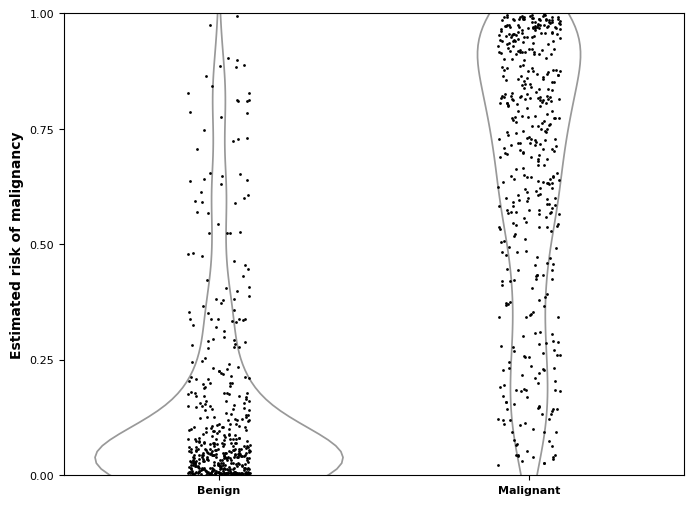

In [ ]:
# Violin plot with jittered dots
dcase['Out1'] = pd.Categorical(dcase['Out1'], categories=['Benign', 'Malignant'], ordered=True)
plt.figure(figsize=(8, 6))
sns.violinplot(x='Out1', y='pmalwo', data=dcase, inner=None, color="white")
sns.stripplot(x='Out1', y='pmalwo', data=dcase, jitter=0.1, color="black", size=2)
plt.xlabel("")
plt.ylabel("Estimated risk of malignancy", fontsize=10, fontweight="bold")
plt.xticks(fontsize=8, fontweight="bold", color="black")
plt.yticks(fontsize=8)
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 5))
plt.show()

### Classification measures

In [ ]:
ClassADNEX = ClassPerfBin(y=dcase['Outcome1'], p=dcase['pmalwo'], cut=0.1)
ClassADNEX

,Accuracy,Balanced Accuracy,Youden index,DOR,Kappa,F1,MCC,Sensitivity,Specificity,PPV,NPV
0,0.794183,0.798698,0.597395,37.360976,0.591846,0.818182,0.624566,0.953917,0.643478,0.716263,0.936709


#### Classification figures

<ipython-input-18-251af4147783>:12: RuntimeWarning: invalid value encountered in scalar divide
  npv = np.sum((dcase['Outcome1'] == 0) & (dcase['pmalwo'] < threshold)) / np.sum(dcase['pmalwo'] < threshold)


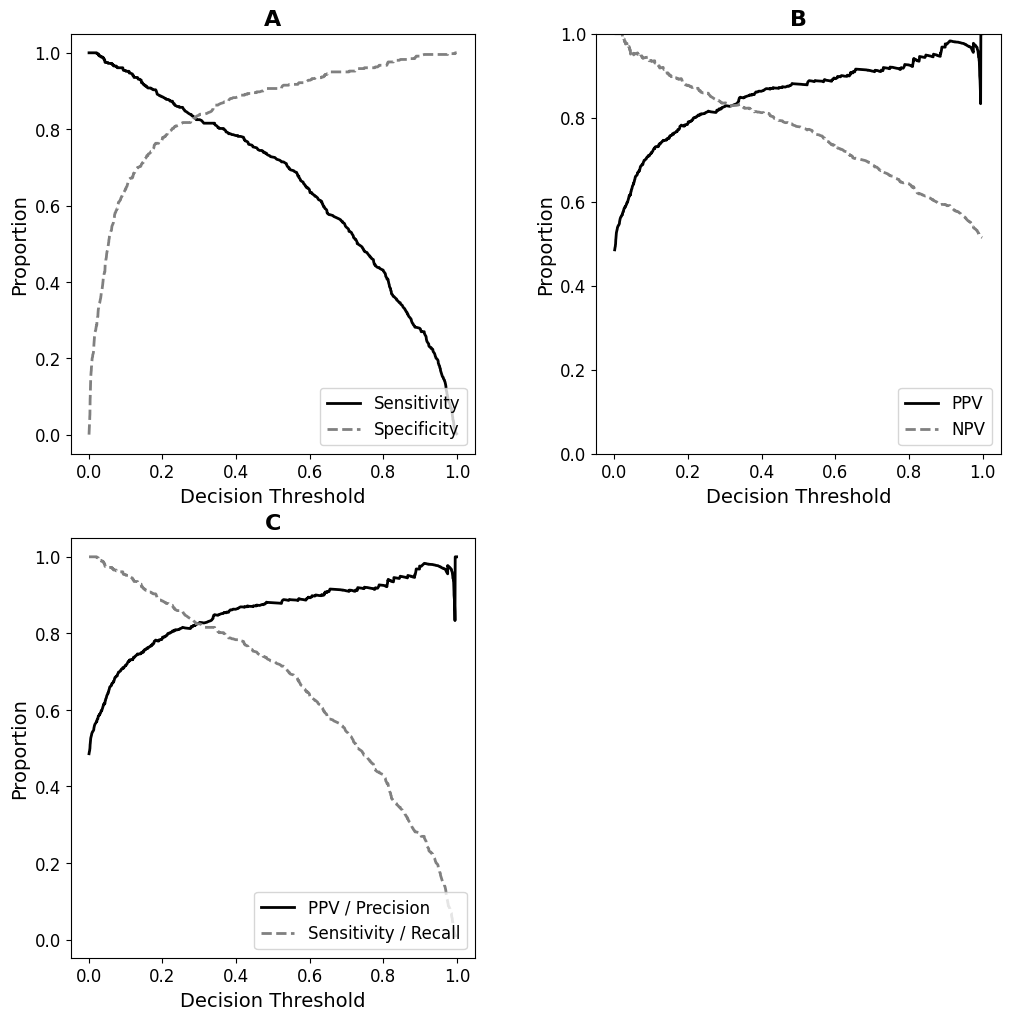

In [ ]:
# Sort probability estimates
adnexsort = np.sort(dcase['pmalwo'])

# Initialize DataFrame for classification points
clsptsadnex = pd.DataFrame(columns=["Sensitivity", "Specificity", "PPV", "NPV"])

# Calculate Sensitivity, Specificity, PPV, and NPV for each threshold
for i, threshold in enumerate(adnexsort):
    sensitivity = np.sum((dcase['pmalwo'] >= threshold) & (dcase['Outcome1'] == 1)) / np.sum(dcase['Outcome1'] == 1)
    specificity = np.sum((dcase['pmalwo'] < threshold) & (dcase['Outcome1'] == 0)) / np.sum(dcase['Outcome1'] == 0)
    ppv = np.sum((dcase['Outcome1'] == 1) & (dcase['pmalwo'] >= threshold)) / np.sum(dcase['pmalwo'] >= threshold)
    npv = np.sum((dcase['Outcome1'] == 0) & (dcase['pmalwo'] < threshold)) / np.sum(dcase['pmalwo'] < threshold)
    clsptsadnex.loc[i] = [sensitivity, specificity, ppv, npv]

# Plot classification performance metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Sensitivity and Specificity
axs[0, 0].plot(adnexsort, clsptsadnex['Sensitivity'], label='Sensitivity', color='black', lw=2)
axs[0, 0].plot(adnexsort, clsptsadnex['Specificity'], label='Specificity', color='grey', linestyle="--", lw=2)
axs[0, 0].set_title("A", fontweight="bold")
axs[0, 0].set_xlabel("Decision Threshold")
axs[0, 0].set_ylabel("Proportion")
axs[0, 0].legend(loc='lower right')

# PPV and NPV
axs[0, 1].plot(adnexsort, clsptsadnex['PPV'], label='PPV', color='black', lw=2)
axs[0, 1].plot(adnexsort, clsptsadnex['NPV'], label='NPV', color='grey', linestyle="--", lw=2)
axs[0, 1].set_title("B", fontweight="bold")
axs[0, 1].set_xlabel("Decision Threshold")
axs[0, 1].set_ylabel("Proportion")
axs[0, 1].legend(loc='lower right')
axs[0, 1].set_ylim(0, 1)

# Precision (PPV) and Recall (Sensitivity)
axs[1, 0].plot(adnexsort, clsptsadnex['PPV'], label='PPV / Precision', color='black', lw=2)
axs[1, 0].plot(adnexsort, clsptsadnex['Sensitivity'], label='Sensitivity / Recall', color='grey', linestyle="--", lw=2)
axs[1, 0].set_title("C", fontweight="bold")
axs[1, 0].set_xlabel("Decision Threshold")
axs[1, 0].set_ylabel("Proportion")
axs[1, 0].legend(loc='lower right')

# Adjust layout and display
fig.delaxes(axs[1, 1])  # Remove unused subplot
plt.subplots_adjust(wspace=0.3, hspace=0.2)  # Increase space between plots
plt.show()

### Clinical utility measures

In [ ]:
UtilADNEX = UtilPerfBin(y = dcase['Outcome1'], p = dcase['pmalwo'], cut = 0.1, costratio = 9)
UtilADNEX

,Net benefit,Standardized net benefit,Expected cost,Threshold for EC
0,0.442704,0.91193,0.354586,0.063169


#### Utility figures

<ipython-input-9-5abd42428c8a>:21: RuntimeWarning: divide by zero encountered in scalar divide
  nb = (tp / len(y_true)) - (fp / len(y_true)) * (threshold / (1 - threshold))
<ipython-input-9-5abd42428c8a>:21: RuntimeWarning: invalid value encountered in scalar multiply
  nb = (tp / len(y_true)) - (fp / len(y_true)) * (threshold / (1 - threshold))
<ipython-input-9-5abd42428c8a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  nb = (tp / len(y_true)) - (fp / len(y_true)) * (threshold / (1 - threshold))


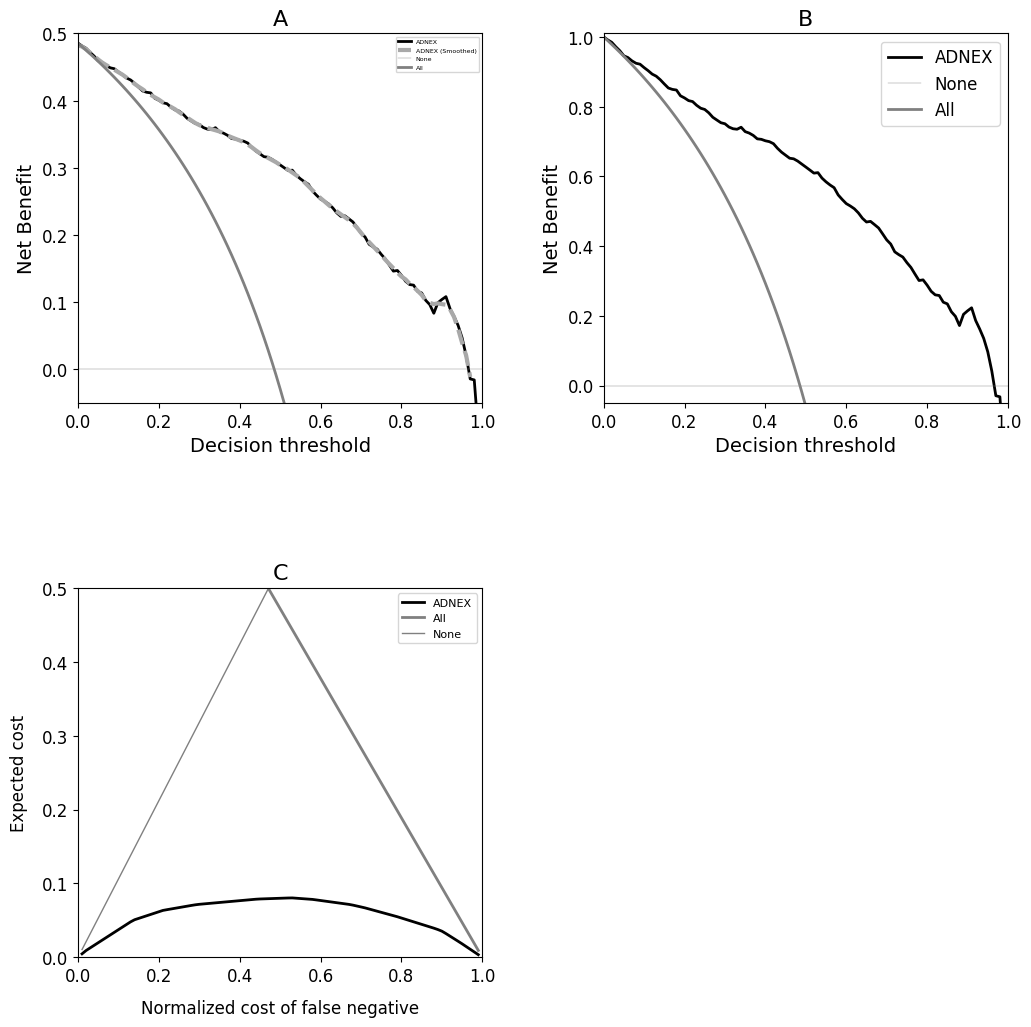

In [ ]:
thresholds = np.linspace(0, 1, 101)
# Calculate Net Benefit at each threshold
nb_values = net_benefit(dcase['Outcome1'], dcase['pmalwo'], thresholds)
nb_TA = net_benefit_all(dcase['Outcome1'], dcase['pmalwo'], thresholds)

# Smooth net benefit curve with moving average (window size 5)
nb_smoothed = uniform_filter1d(nb_values, size=5)

# GET DATA TO PLOT EC BY NORMALIZED COST OF A FALSE POSITIVE
# EC values for the model
mean_outcome = dcase['Outcome1'].mean()

ncostfp = np.arange(1, 100) / 100
ecmodel = ecplotv(y = dcase['Outcome1'], p = dcase['pmalwo'],
                  ncostfp = ncostfp)

# EC values for treat all and treat none
ecTA = ncostfp * (mean_outcome / (1 - mean_outcome))
ecTN = (1 - ncostfp) * ((1 - mean_outcome) / mean_outcome)


fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Panel A (Top left)
axs[0, 0].plot(thresholds, nb_values, label="ADNEX", color="black", lw=2)
axs[0, 0].plot(thresholds, nb_smoothed, label="ADNEX (Smoothed)", color="darkgray", linestyle="--", lw=3)
axs[0, 0].axhline(0, color="gray", linestyle="-", lw=0.3, label="None")
axs[0, 0].plot(thresholds, nb_TA, color="gray", linestyle="-", lw=2, label="All")
axs[0, 0].set_xlabel("Decision threshold")
axs[0, 0].set_ylabel("Net Benefit")
axs[0, 0].set_ylim(-0.05, 0.5)
axs[0, 0].set_xlim(0, 1)
axs[0, 0].legend(loc="upper right", fontsize = 4.5)
axs[0, 0].set_title("A")
axs[0, 0].grid(False)

# Panel B (Top right)
axs[0, 1].plot(thresholds, nb_values / np.mean(dcase['Outcome1']), label="ADNEX", color="black", lw=2)
axs[0, 1].axhline(0, color="gray", linestyle="-", lw=0.3, label="None")
axs[0, 1].plot(thresholds, nb_TA / np.mean(dcase['Outcome1']), color="gray", linestyle="-", lw=2, label="All")
axs[0, 1].set_xlabel("Decision threshold")
axs[0, 1].set_ylabel("Net Benefit")
axs[0, 1].set_ylim(-0.05, 1.01)
axs[0, 1].set_xlim(0, 1)
axs[0, 1].legend(loc="upper right")
axs[0, 1].set_title("B")
axs[0, 1].grid(False)

# Panel C (Bottom left) - EC Plot
x_vals = 1 - ncostfp
axs[1, 0].plot(x_vals, ecmodel.iloc[0, :], color="black", linewidth=2, label="ADNEX")
axs[1, 0].plot(x_vals, ecTA, color="gray", linewidth=2, label="All")
axs[1, 0].plot(x_vals, ecTN, color="gray", linewidth=1, label="None")
axs[1, 0].set_xlim(0, 1)
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].set_xlabel("Normalized cost of false negative", fontsize=12, labelpad=10)
axs[1, 0].set_ylabel("Expected cost", fontsize=12, labelpad=10)
axs[1, 0].set_title("C")
axs[1, 0].legend(loc="upper right", fontsize=8)
axs[1, 0].grid(False)
# Empty panel (Bottom right)
axs[1, 1].axis('off')  # Hides the bottom right panel

# Adjust layout and show the plots
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increase space between plots
plt.show()

### Bootstrapping

In [ ]:
# Set random seed for reproducibility
np.random.seed(2345)
nboot = 10 # In the paper 1000 are used

# Prepare the bootstrapping results storage
resadnex = pd.DataFrame(np.nan, index=range(nboot), columns=range(34))

# Perform bootstrapping
for bootnr in range(nboot):
    bootdata = dcase.sample(n=len(dcase), replace=True)  # Bootstrap sample with replacement

    resadnex.iloc[bootnr, 0:9] = OvPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwo'])
    resadnex.iloc[bootnr, 9:13] = DiscPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwo'])
    resadnex.iloc[bootnr, 13:19] = CalPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwo'], flexcal="loess")
    resadnex.iloc[bootnr, 19:30] = ClassPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwo'], cut=0.1)
    resadnex.iloc[bootnr, 30:34] = UtilPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwo'], cut=0.1, costratio=9)

# Calculate 95% Confidence Intervals (percentile method)
pctciu = pd.DataFrame(index=range(34), columns=["LCL", "UCL"])
for i in range(34):
    pctciu.iloc[i, 0], pctciu.iloc[i, 1] = np.quantile(resadnex.iloc[:, i], [0.025, 0.975])

# Combine point estimates and CIs
bootci = pd.DataFrame({
    "Point estimate": np.concatenate([OvADNEX.values.flatten(), DiscADNEX.values.flatten(), CalADNEX.values.flatten(),
                                      ClassADNEX.values.flatten(), UtilADNEX.values.flatten()]),
    "LCL": pctciu["LCL"],
    "UCL": pctciu["UCL"]
}).round(3).astype(str)

# Set column and row names
bootci.columns = ["Point estimate", "LCL", "UCL"]
bootci.index = list(OvADNEX.columns) + list(DiscADNEX.columns) + list(CalADNEX.columns) + \
                list(ClassADNEX.columns) + list(UtilADNEX.columns)

bootci

,Point estimate,LCL,UCL
Loglikelihood,-370.012,-403.7226952020083,-346.15936534714376
Logloss,370.012,346.1593653471438,403.72269520200837
Brier,0.133,0.12331103216830185,0.14645015326164246
Scaled Brier,0.469,0.41379515824290114,0.5064480862733679
McFadden R2,0.403,0.3481684507806541,0.4411320246864389
Cox-Snell R2,0.427,0.38269171674252306,0.457250106948896
Nagelkerke R2,0.57,0.5103712500303378,0.609789106452163
Discrimination slope,0.509,0.4750775740651517,0.5361927199638242
MAPE,0.243,0.2304984299703859,0.25766417520959173
AUROC,0.911,0.8957730913251508,0.9239014482389097


## Recalibration
In this section we calculate the performance measures after logistic recalibration

In [ ]:
# Logistic recalibration: update risk estimates for the recalibrated model
log_reg = LogisticRegression()
log_reg.fit(dcase[['logit_pmalwo']], dcase['Outcome1'])
dcase['pmalwou'] = log_reg.predict_proba(dcase[['logit_pmalwo']])[:, 1]

### Discrimination

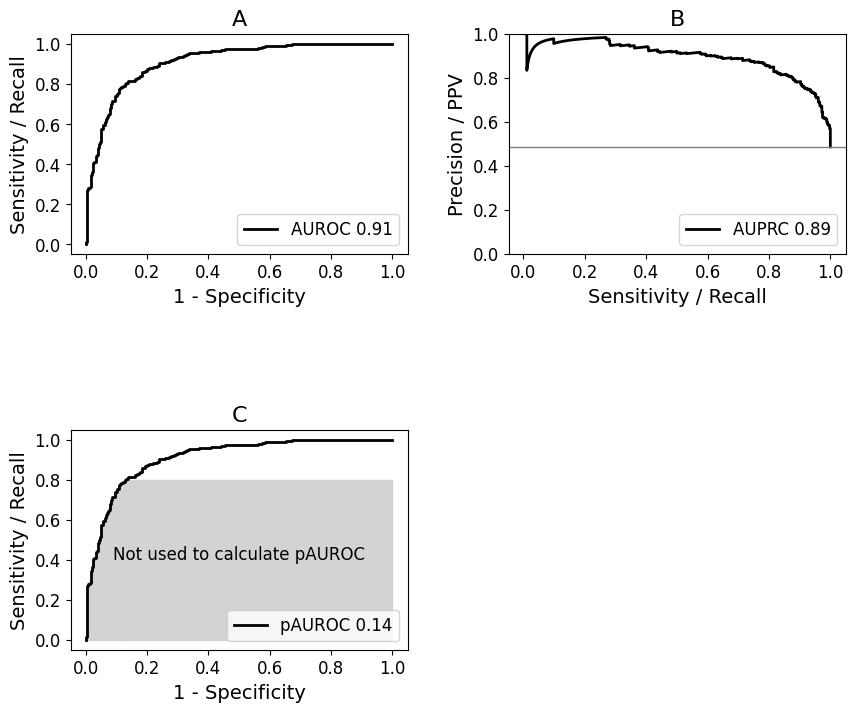

,AUROC,AUPRC,AP,pAUROC
0,0.911385,0.894914,0.895251,0.141112


In [ ]:
DiscADNEXu = DiscPerfBin(y=dcase['Outcome1'], p=dcase['pmalwou'])
DiscADNEXu
# Get ROC curve points
adnexusort = np.sort(dcase['pmalwou'])
rocptsadnexu = pd.DataFrame({
    "Sensitivity": [np.sum(dcase['pmalwou'][dcase['Outcome1'] == 1] >= thresh) / np.sum(dcase['Outcome1'] == 1) for thresh in adnexusort],
    "1-Specificity": [np.sum(dcase['pmalwou'][dcase['Outcome1'] == 0] >= thresh) / np.sum(dcase['Outcome1'] == 0) for thresh in adnexusort]
})

# Get PR curve points
prcptsadnexu = pd.DataFrame({
    "Recall": [np.sum(dcase['pmalwou'][dcase['Outcome1'] == 1] >= thresh) / np.sum(dcase['Outcome1'] == 1) for thresh in adnexusort],
    "Precision": [np.sum(dcase['pmalwou'][dcase['Outcome1'] == 1] >= thresh) / np.sum(dcase['pmalwou'] >= thresh) for thresh in adnexusort]
})


# Discrimination Performance - AUROC calculation
fpr, tpr, _ = roc_curve(dcase['Outcome1'], dcase['pmalwou'])
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(dcase['Outcome1'], dcase['pmalwou'])
pr_auc = auc(recall, precision)

# Partial AUROC (pAUROC) - Considering only specific ranges of sensitivity

# Select points where TPR is above the threshold
tpr_threshold = 0.8
partial_fpr = fpr[tpr >= tpr_threshold]
partial_tpr = tpr[tpr >= tpr_threshold]

adjusted_tpr = partial_tpr - tpr_threshold

# Compute the partial AUC above TPR = 0.8
partial_auc_above_threshold = np.trapz(adjusted_tpr, partial_fpr)

# Plotting ROC and PR curves
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# ROC Curve
axs[0, 0].plot(rocptsadnexu["1-Specificity"], rocptsadnexu["Sensitivity"], color="black", lw=2)
axs[0, 0].set_title("A")
axs[0, 0].set_xlabel("1 - Specificity")
axs[0, 0].set_ylabel("Sensitivity / Recall")
axs[0, 0].legend(["AUROC 0.91"], loc="lower right")

# PR Curve
axs[0, 1].plot(prcptsadnexu["Recall"], prcptsadnexu["Precision"], color="black", lw=2)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].axhline(np.mean(dcase['Outcome1']), color="gray", lw=1)
axs[0, 1].set_title("B")
axs[0, 1].set_xlabel("Sensitivity / Recall")
axs[0, 1].set_ylabel("Precision / PPV")
axs[0, 1].legend(["AUPRC 0.89"], loc="lower right")

# Panel C: Partial ROC Curve
axs[1, 0].plot(fpr, tpr, color='black', lw=2)
axs[1, 0].fill_between(fpr, tpr, where=(tpr <= tpr_threshold), color="lightgray", step="post")
axs[1, 0].fill_between(fpr, 0.8, where=(tpr > tpr_threshold), color="lightgray", step="post")
axs[1, 0].text(0.5, 0.4, "Not used to calculate pAUROC", ha="center")
axs[1, 0].set_title("C")
axs[1, 0].set_xlabel("1 - Specificity")
axs[1, 0].set_ylabel("Sensitivity / Recall")
axs[1, 0].legend([f'pAUROC {partial_auc_above_threshold:.2f}'], loc='lower right')

fig.delaxes(axs[1,1])
plt.subplots_adjust(wspace=0.3, hspace=0.8)  # Increase space between plots
plt.show()
DiscADNEXu

### Calibration

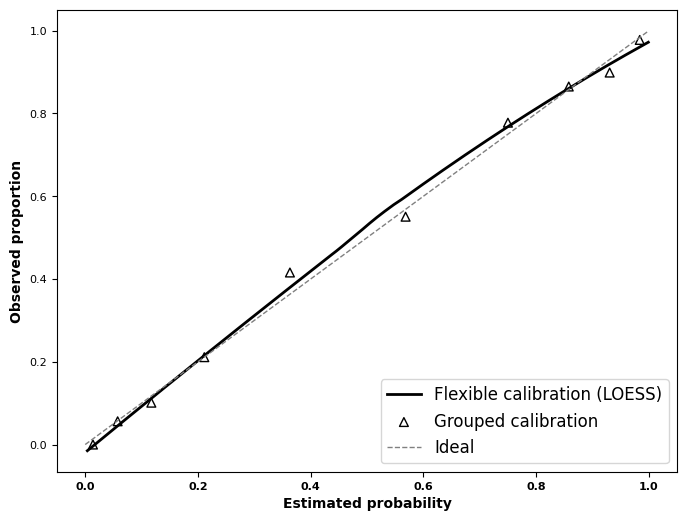

,O:E ratio,Cal. intercept,Cal. slope,ECI,ICI,ECE
0,1.000125,0.000508,0.999291,0.002074,0.014183,0.017463


In [ ]:
loess_adnexu = localreg(x=np.array(dcase['pmalwou']), y=np.array(dcase['Outcome1']), frac=0.75, degree=2)
dcase["loessu"] = loess_adnexu
dcase = dcase.sort_values(by="loessu")

ngr = 10
hsl = pd.DataFrame({'x': dcase['pmalwou'], 'y': dcase['Outcome1']})
hsl['x_quantile'] = pd.qcut(hsl['x'], q=ngr)
mean_hsl = hsl.groupby('x_quantile', observed=True).agg(mean_x=('x', 'mean'), mean_y=('y', 'mean')).reset_index()

plt.figure(figsize=(8, 6))
plt.plot(dcase['pmalwou'], dcase['loessu'], color='black', lw=2)
plt.scatter(mean_hsl['mean_x'], mean_hsl['mean_y'], color='black', s=40, marker='^', facecolors='none')
plt.xlabel("Estimated probability", fontsize=10, fontweight="bold")
plt.ylabel("Observed proportion", fontsize=10, fontweight="bold")
plt.xticks(fontsize=8, fontweight="bold", color="black")
plt.yticks(fontsize=8)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
# plt.hist(dcase['pmalwo'][dcase['Outcome1'] == 0], bins=20, color='lightgray', alpha=0.5, density=True)
# plt.hist(dcase['pmalwo'][dcase['Outcome1'] == 1], bins=20, color='black', alpha=0.5, density=True)
plt.legend(["Flexible calibration (LOESS)", "Grouped calibration", "Ideal"], loc='lower right')
plt.show()

CalADNEXu = CalPerfBin(y=dcase['Outcome1'], p=dcase['pmalwou'], flexcal="loess")
CalADNEXu

### Overall

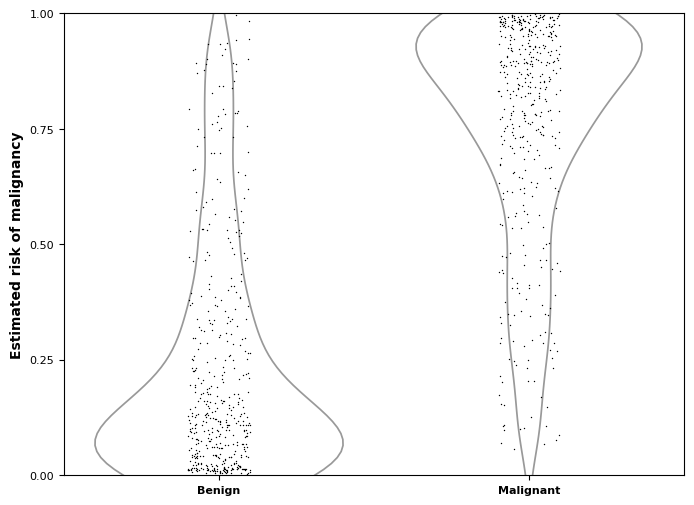

,Loglikelihood,Logloss,Brier,Scaled Brier,McFadden R2,Cox-Snell R2,Nagelkerke R2,Discrimination slope,MAPE
0,-336.687164,336.687164,0.118316,0.526336,0.456338,0.468596,0.624971,0.524445,0.237575


In [ ]:
OvADNEXu = OvPerfBin(y=dcase['Outcome1'], p=dcase['pmalwou'])
# Violin plot with jittered dots
dcase['Out1'] = pd.Categorical(dcase['Out1'], categories=['Benign', 'Malignant'], ordered=True)
plt.figure(figsize=(8, 6))
sns.violinplot(x='Out1', y='pmalwou', data=dcase, inner=None, color="white")
sns.stripplot(x='Out1', y='pmalwou', data=dcase, jitter=0.1, color="black", size=1)
plt.xlabel("")
plt.ylabel("Estimated risk of malignancy", fontsize=10, fontweight="bold")
plt.xticks(fontsize=8, fontweight="bold", color="black")
plt.yticks(fontsize=8)
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 5))
plt.show()
OvADNEXu

### Classification

<ipython-input-26-eb7a780f471b>:7: RuntimeWarning: invalid value encountered in scalar divide
  "NPV": [np.sum(dcase['Outcome1'][dcase['pmalwou'] < thresh] == 0) / np.sum(dcase['pmalwou'] < thresh) for thresh in adnexusort]


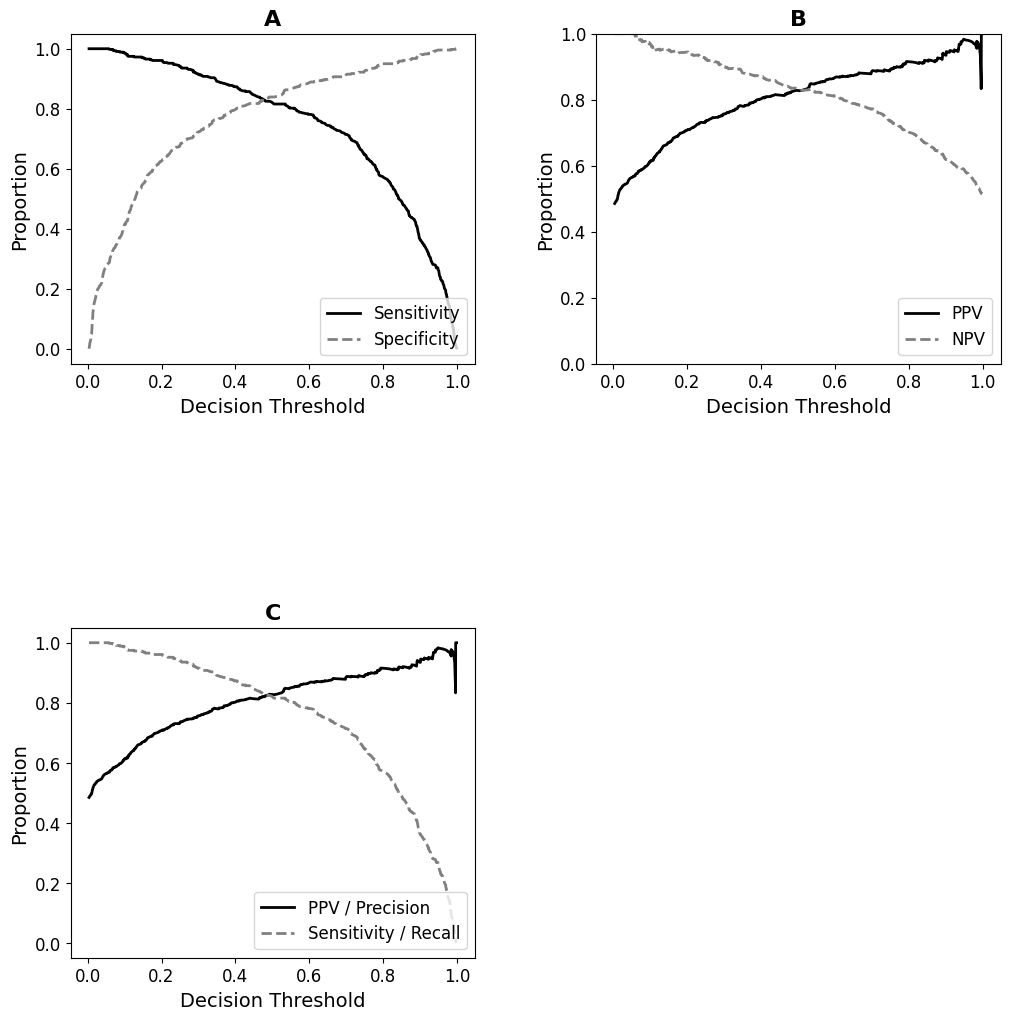

,Accuracy,Balanced Accuracy,Youden index,DOR,Kappa,F1,MCC,Sensitivity,Specificity,PPV,NPV
0,0.692394,0.700696,0.401393,50.649318,0.394634,0.756852,0.483998,0.986175,0.415217,0.61406,0.969543


In [ ]:
ClassADNEXu = ClassPerfBin(y=dcase['Outcome1'], p=dcase['pmalwou'], cut=0.1)

clsptsadnexu = pd.DataFrame({
    "Sensitivity": [np.sum(dcase['pmalwou'][dcase['Outcome1'] == 1] >= thresh) / np.sum(dcase['Outcome1'] == 1) for thresh in adnexusort],
    "Specificity": [np.sum(dcase['pmalwou'][dcase['Outcome1'] == 0] < thresh) / np.sum(dcase['Outcome1'] == 0) for thresh in adnexusort],
    "PPV": [np.sum(dcase['Outcome1'][dcase['pmalwou'] >= thresh] == 1) / np.sum(dcase['pmalwou'] >= thresh) for thresh in adnexusort],
    "NPV": [np.sum(dcase['Outcome1'][dcase['pmalwou'] < thresh] == 0) / np.sum(dcase['pmalwou'] < thresh) for thresh in adnexusort]
})

# Plot classification performance metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Sensitivity and Specificity
axs[0, 0].plot(adnexusort, clsptsadnexu['Sensitivity'], label='Sensitivity', color='black', lw=2)
axs[0, 0].plot(adnexusort, clsptsadnexu['Specificity'], label='Specificity', color='grey', linestyle="--", lw=2)
axs[0, 0].set_title("A", fontweight="bold")
axs[0, 0].set_xlabel("Decision Threshold")
axs[0, 0].set_ylabel("Proportion")
axs[0, 0].legend(loc='lower right')

# PPV and NPV
axs[0, 1].plot(adnexusort, clsptsadnexu['PPV'], label='PPV', color='black', lw=2)
axs[0, 1].plot(adnexusort, clsptsadnexu['NPV'], label='NPV', color='grey', linestyle="--", lw=2)
axs[0, 1].set_title("B", fontweight="bold")
axs[0, 1].set_xlabel("Decision Threshold")
axs[0, 1].set_ylabel("Proportion")
axs[0, 1].legend(loc='lower right')
axs[0, 1].set_ylim(0, 1)

# Precision (PPV) and Recall (Sensitivity)
axs[1, 0].plot(adnexusort, clsptsadnexu['PPV'], label='PPV / Precision', color='black', lw=2)
axs[1, 0].plot(adnexusort, clsptsadnexu['Sensitivity'], label='Sensitivity / Recall', color='grey', linestyle="--", lw=2)
axs[1, 0].set_title("C", fontweight="bold")
axs[1, 0].set_xlabel("Decision Threshold")
axs[1, 0].set_ylabel("Proportion")
axs[1, 0].legend(loc='lower right')

# Adjust layout and display
fig.delaxes(axs[1, 1])  # Remove unused subplot
plt.subplots_adjust(wspace=0.3, hspace=0.8)  # Increase space between plots
plt.show()
ClassADNEXu

### Clinical utility

<ipython-input-9-5abd42428c8a>:21: RuntimeWarning: divide by zero encountered in scalar divide
  nb = (tp / len(y_true)) - (fp / len(y_true)) * (threshold / (1 - threshold))
<ipython-input-9-5abd42428c8a>:21: RuntimeWarning: invalid value encountered in scalar multiply
  nb = (tp / len(y_true)) - (fp / len(y_true)) * (threshold / (1 - threshold))
<ipython-input-9-5abd42428c8a>:31: RuntimeWarning: divide by zero encountered in scalar divide
  nb = (tp / len(y_true)) - (fp / len(y_true)) * (threshold / (1 - threshold))


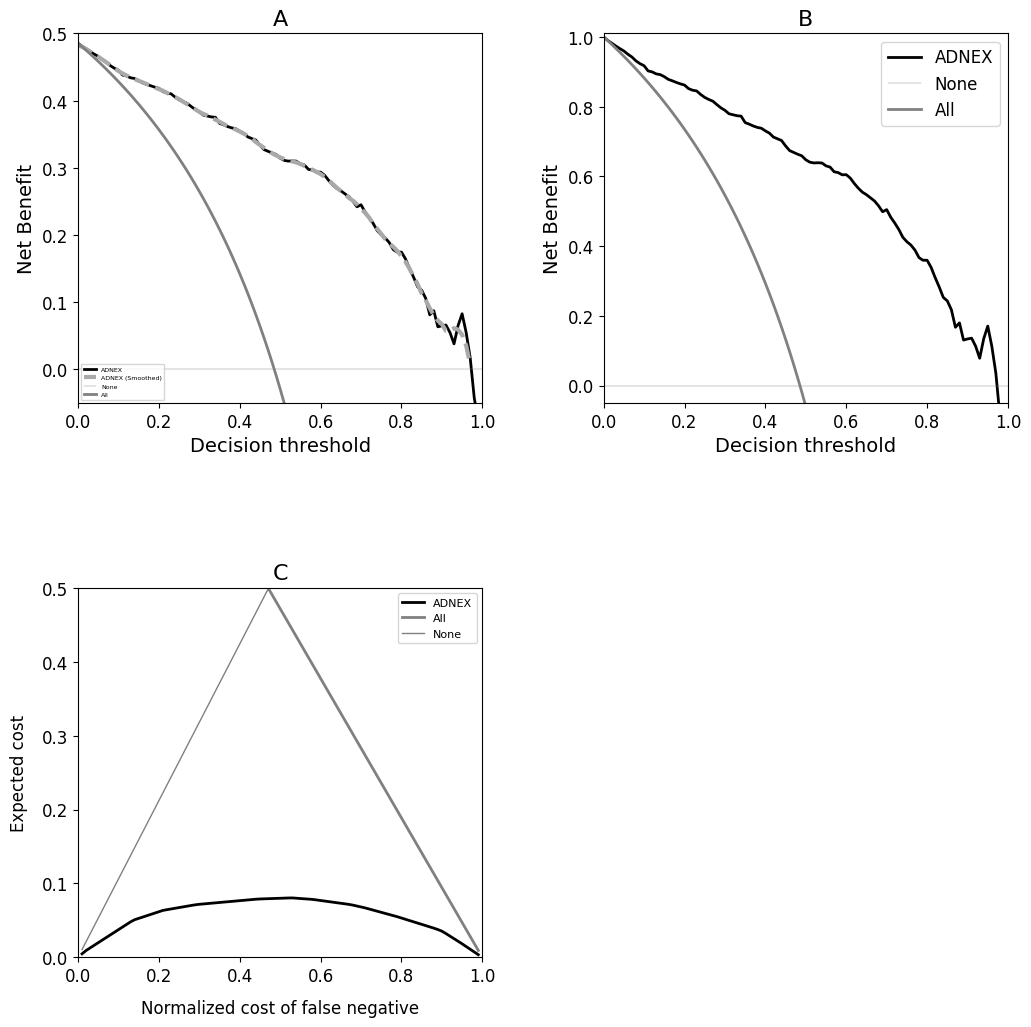

,Net benefit,Standardized net benefit,Expected cost,Threshold for EC
0,0.445314,0.917307,0.354586,0.146956


In [ ]:
thresholds = np.linspace(0, 1, 101)
# Calculate Net Benefit at each threshold
nb_values = net_benefit(dcase['Outcome1'], dcase['pmalwou'], thresholds)
nb_TA = net_benefit_all(dcase['Outcome1'], dcase['pmalwou'], thresholds)

# Smooth net benefit curve with moving average (window size 5)
nb_smoothed = uniform_filter1d(nb_values, size=5)

# GET DATA TO PLOT EC BY NORMALIZED COST OF A FALSE POSITIVE
# EC values for the model
mean_outcome = dcase['Outcome1'].mean()

ncostfp = np.arange(1, 100) / 100
ecmodel = ecplotv(y = dcase['Outcome1'], p = dcase['pmalwou'],
                  ncostfp = ncostfp)

# EC values for treat all and treat none
ecTA = ncostfp * (mean_outcome / (1 - mean_outcome))
ecTN = (1 - ncostfp) * ((1 - mean_outcome) / mean_outcome)

# Create the figure with 2x2 grid (subplots)
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Panel A (Top left)
axs[0, 0].plot(thresholds, nb_values, label="ADNEX", color="black", lw=2)
axs[0, 0].plot(thresholds, nb_smoothed, label="ADNEX (Smoothed)", color="darkgray", linestyle="--", lw=3)
axs[0, 0].axhline(0, color="gray", linestyle="-", lw=0.3, label="None")
axs[0, 0].plot(thresholds, nb_TA, color="gray", linestyle="-", lw=2, label="All")
axs[0, 0].set_xlabel("Decision threshold")
axs[0, 0].set_ylabel("Net Benefit")
axs[0, 0].set_ylim(-0.05, 0.5)
axs[0, 0].set_xlim(0, 1)
axs[0, 0].legend(loc="lower left", fontsize = 4.5)
axs[0, 0].set_title("A")
axs[0, 0].grid(False)

# Panel B (Top right)
axs[0, 1].plot(thresholds, nb_values / np.mean(dcase['Outcome1']), label="ADNEX", color="black", lw=2)
axs[0, 1].axhline(0, color="gray", linestyle="-", lw=0.3, label="None")
axs[0, 1].plot(thresholds, nb_TA / np.mean(dcase['Outcome1']), color="gray", linestyle="-", lw=2, label="All")
axs[0, 1].set_xlabel("Decision threshold")
axs[0, 1].set_ylabel("Net Benefit")
axs[0, 1].set_ylim(-0.05, 1.01)
axs[0, 1].set_xlim(0, 1)
axs[0, 1].legend(loc="upper right")
axs[0, 1].set_title("B")
axs[0, 1].grid(False)

# Panel C (Bottom left) - EC Plot
x_vals = 1 - ncostfp
axs[1, 0].plot(x_vals, ecmodel.iloc[0, :], color="black", linewidth=2, label="ADNEX")
axs[1, 0].plot(x_vals, ecTA, color="gray", linewidth=2, label="All")
axs[1, 0].plot(x_vals, ecTN, color="gray", linewidth=1, label="None")
axs[1, 0].set_xlim(0, 1)
axs[1, 0].set_ylim(0, 0.5)
axs[1, 0].set_xlabel("Normalized cost of false negative", fontsize=12, labelpad=10)
axs[1, 0].set_ylabel("Expected cost", fontsize=12, labelpad=10)
axs[1, 0].set_title("C")
axs[1, 0].legend(loc="upper right", fontsize=8)
axs[1, 0].grid(False)

# Empty panel (Bottom right)
axs[1, 1].axis('off')  # Hides the bottom right panel

# Adjust layout and show the plots
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Increase space between plots
plt.show()

# OBTAIN UTILITY MEASURES
UtilADNEXu = UtilPerfBin(y = dcase['Outcome1'], p = dcase['pmalwou'], cut = 0.1, costratio = 9)
UtilADNEXu

### Bootstrap

In [ ]:
# Set random seed for reproducibility
np.random.seed(2345)
nboot = 10

# Prepare the bootstrapping results storage
resadnexu = pd.DataFrame(np.nan, index=range(nboot), columns=range(34))

# Perform bootstrapping
for bootnr in range(nboot):
    bootdata = dcase.sample(n=len(dcase), replace=True)  # Bootstrap sample with replacement

    resadnexu.iloc[bootnr, 0:9] = OvPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwou'])
    resadnexu.iloc[bootnr, 9:13] = DiscPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwou'])
    resadnexu.iloc[bootnr, 13:19] = CalPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwou'], flexcal="loess")
    resadnexu.iloc[bootnr, 19:30] = ClassPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwou'], cut=0.1)
    resadnexu.iloc[bootnr, 30:34] = UtilPerfBin(y=bootdata['Outcome1'], p=bootdata['pmalwou'], cut=0.1, costratio=9)

# Calculate 95% Confidence Intervals (percentile method)
pctciu = pd.DataFrame(index=range(34), columns=["LCL", "UCL"])
for i in range(34):
    pctciu.iloc[i, 0], pctciu.iloc[i, 1] = np.quantile(resadnexu.iloc[:, i], [0.025, 0.975])

# Combine point estimates and CIs
bootciu = pd.DataFrame({
    "Point estimate": np.concatenate([OvADNEXu.values.flatten(), DiscADNEXu.values.flatten(), CalADNEXu.values.flatten(),
                                      ClassADNEXu.values.flatten(), UtilADNEXu.values.flatten()]),
    "LCL": pctciu["LCL"],
    "UCL": pctciu["UCL"]
}).round(3).astype(str)

# Set column and row names
bootciu.columns = ["Point estimate", "LCL", "UCL"]
bootciu.index = list(OvADNEX.columns) + list(DiscADNEX.columns) + list(CalADNEX.columns) + \
                list(ClassADNEX.columns) + list(UtilADNEX.columns)

bootciu



,Point estimate,LCL,UCL
Loglikelihood,-336.687,-365.8002057391452,-313.6139297588368
Logloss,336.687,313.6139297588367,365.80020573914527
Brier,0.118,0.10959457224869057,0.13022288180059816
Scaled Brier,0.526,0.47741599030369003,0.5611401355503983
McFadden R2,0.456,0.4083068367946391,0.49350323118789213
Cox-Snell R2,0.469,0.4314656121673682,0.4951580772520917
Nagelkerke R2,0.625,0.5759180774761579,0.6604419019374098
Discrimination slope,0.524,0.49435148737886797,0.5497488325645731
MAPE,0.238,0.2251581487089819,0.2523889330720872
AUROC,0.911,0.8957730913251508,0.9239014482389097
